In [1]:
# Imports
import reservoirpy as rp

Neuron demo

WARNING    Cannot use Cython, a test compilation failed: 'charmap' codec can't decode byte 0x81 in position 56: character maps to <undefined> (UnicodeDecodeError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


nr of spikes: 0


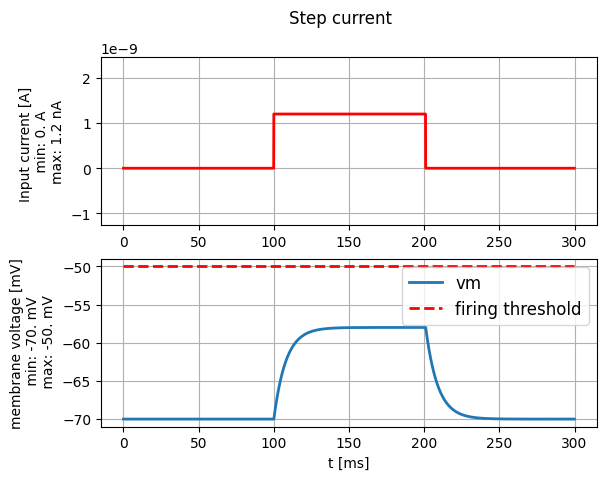

nr of spikes: 5


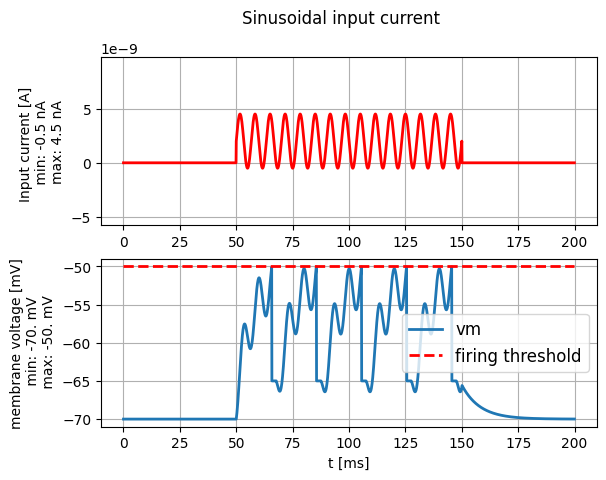

In [1]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory, plot_tools

LIF.getting_started()
LIF.print_default_parameters()

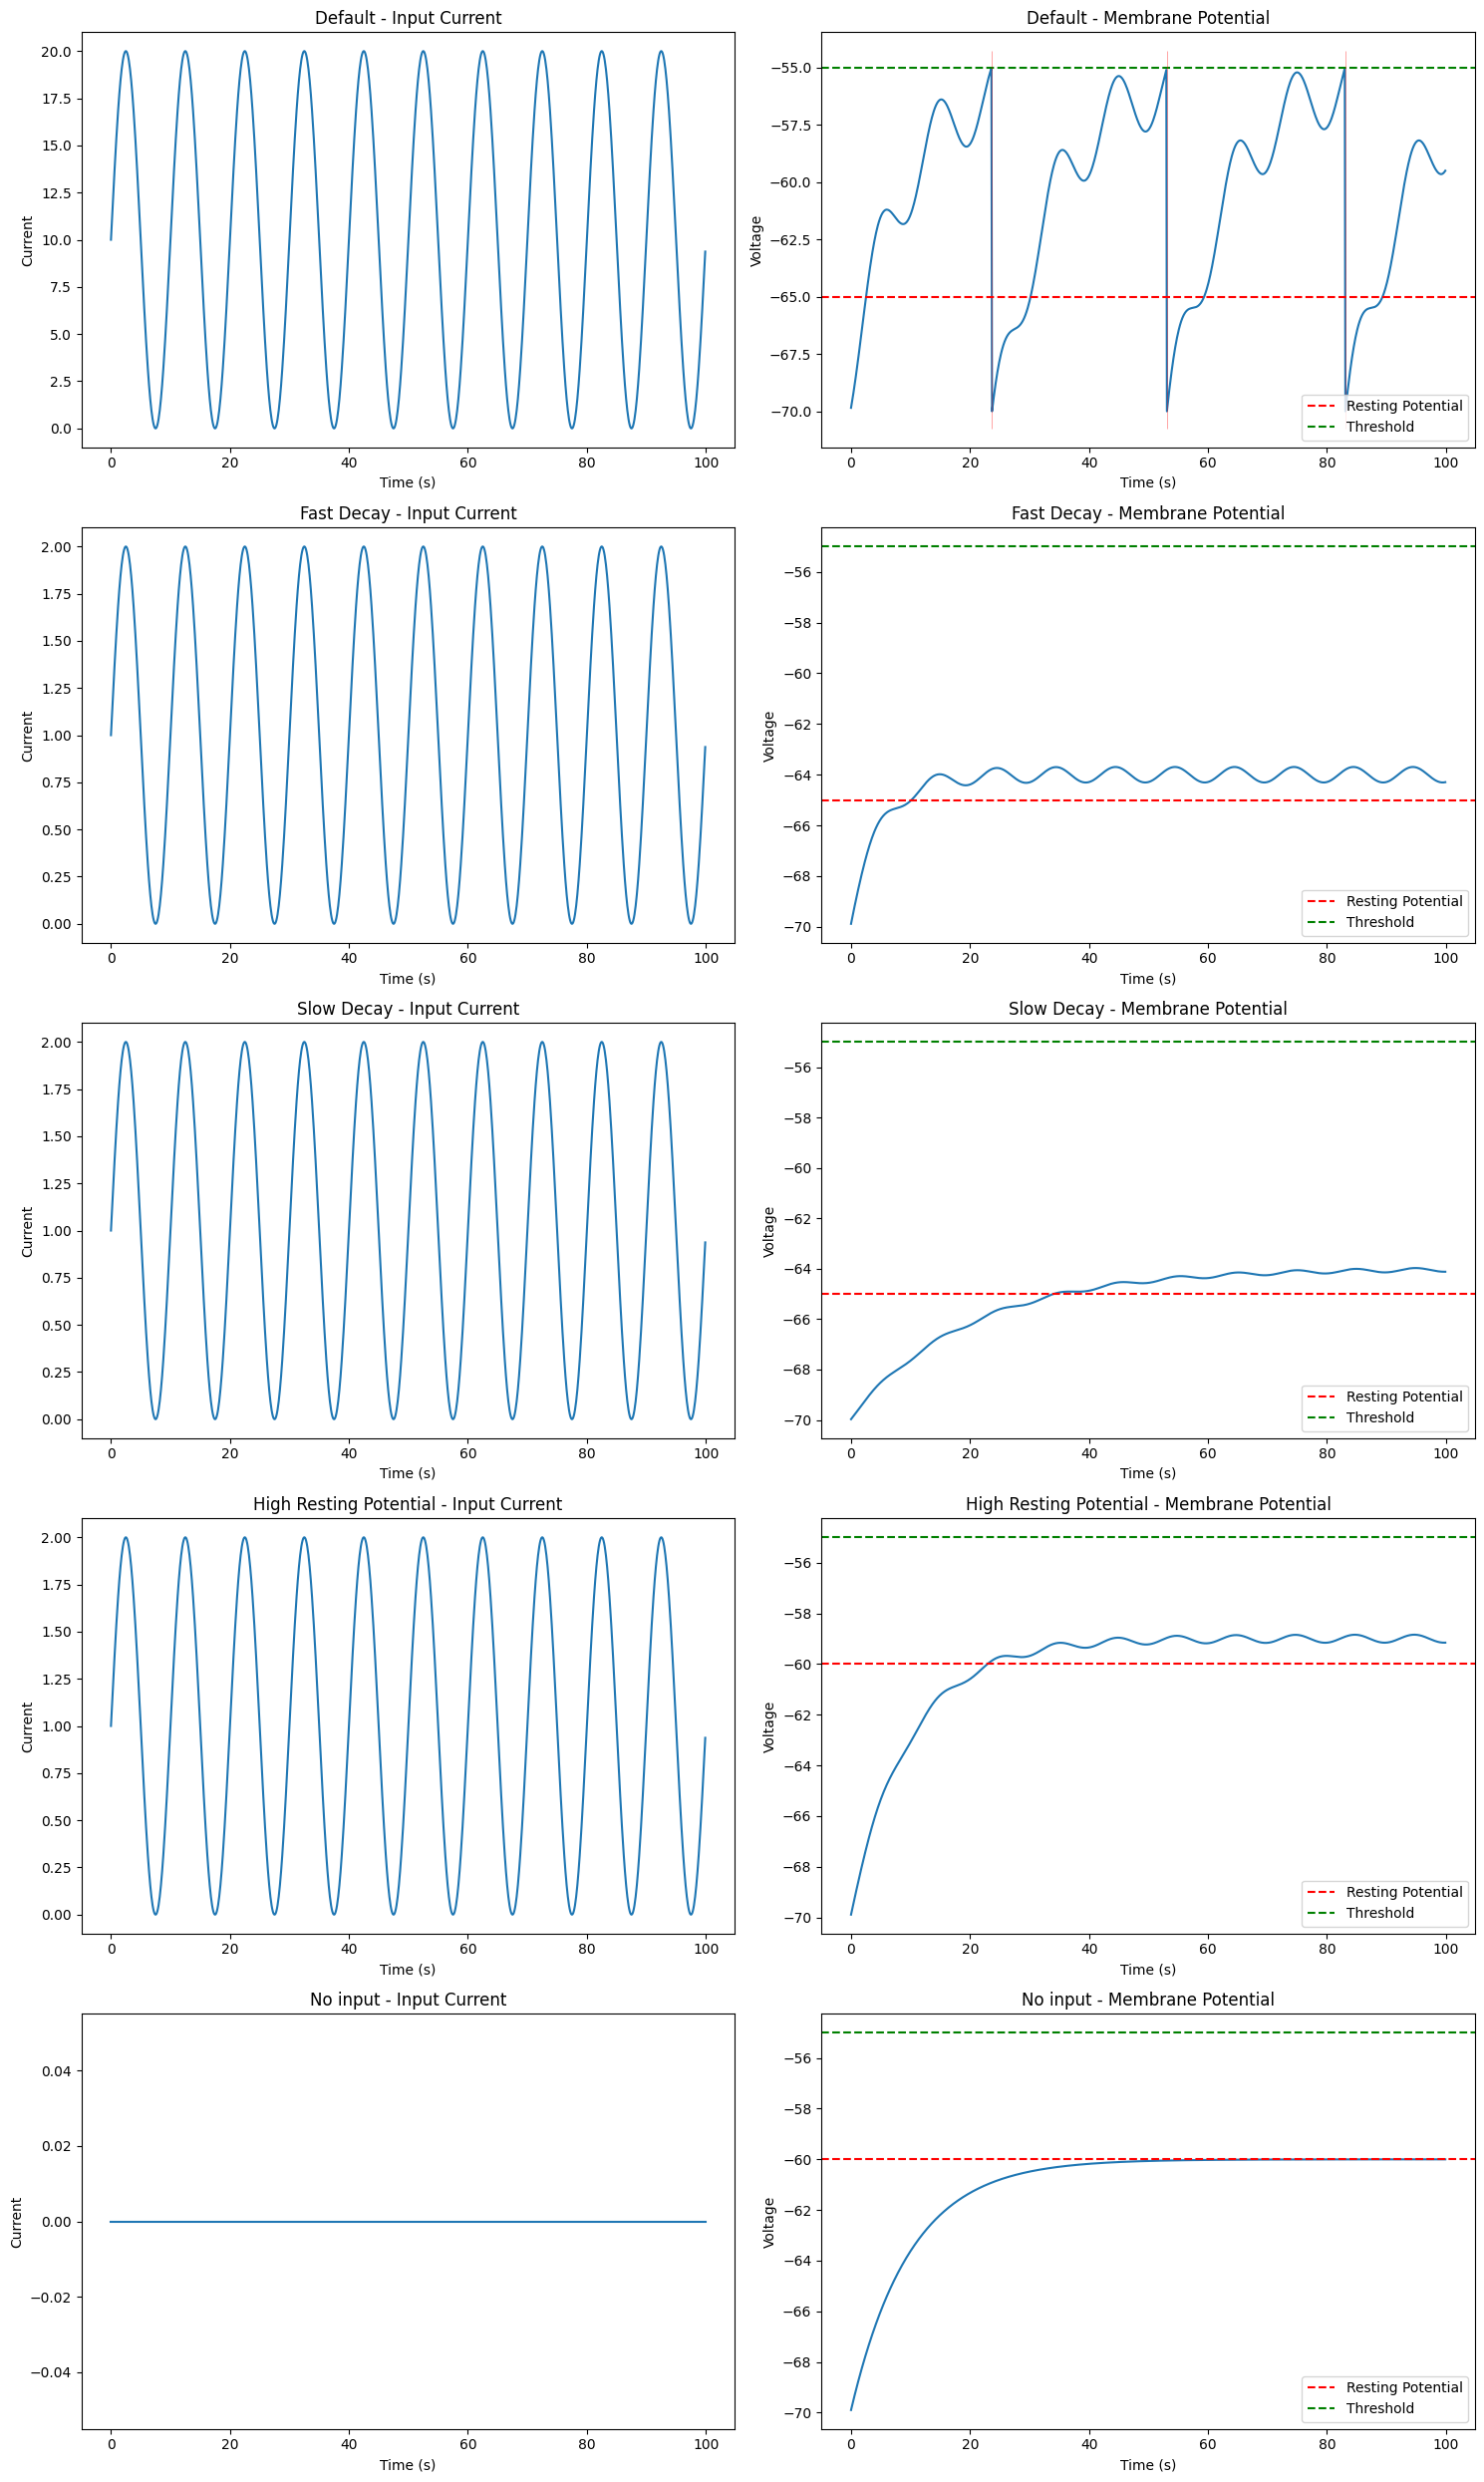

In [16]:
import torch
import matplotlib.pyplot as plt
from collections import namedtuple

class LIFNeuron(torch.nn.Module):
    def __init__(self, tau_m, v_threshold, v_reset, v_rest):
        super().__init__()
        self.tau_m = tau_m
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.v_rest = v_rest
        self.v = self.v_reset

    def forward(self, input_current, dt):
        dv = (input_current + (self.v_rest - self.v)) / self.tau_m
        self.v += dv * dt
        spike = self.v >= self.v_threshold
        self.v = torch.where(spike, torch.tensor(self.v_reset), self.v)
        return spike, self.v

def generate_input(duration, dt, frequency, strength):
    time = torch.arange(0, duration, dt)
    input_current = strength * torch.sin(2 * torch.pi * frequency * time) + strength
    return time, input_current

def run_simulation(params):
    neuron = LIFNeuron(params.tau_m, params.v_threshold, params.v_reset, params.v_rest)
    time, input_current = generate_input(params.duration, params.dt, params.frequency, params.strength)
    
    membrane_potential = torch.zeros_like(time)
    spikes = torch.zeros_like(time)
    
    for i in range(len(time)):
        spike, v = neuron(input_current[i], params.dt)
        membrane_potential[i] = v
        spikes[i] = spike
    
    return time, input_current, membrane_potential, spikes

def plot_results(results):
    num_sets = len(results)
    fig, axs = plt.subplots(num_sets, 2, figsize=(15, 5 * num_sets))
    
    for i, (label, (time, input_current, membrane_potential, spikes)) in enumerate(results.items()):
        # Input Current plot
        axs[i, 0].set_title(f"{label} - Input Current")
        axs[i, 0].plot(time, input_current)
        axs[i, 0].set_xlabel("Time (s)")
        axs[i, 0].set_ylabel("Current")
        
        # Membrane Potential plot
        axs[i, 1].set_title(f"{label} - Membrane Potential")
        axs[i, 1].plot(time, membrane_potential)
        axs[i, 1].axhline(y=param_sets[label].v_rest, color='r', linestyle='--', label='Resting Potential')
        axs[i, 1].axhline(y=param_sets[label].v_threshold, color='g', linestyle='--', label='Threshold')
        axs[i, 1].set_xlabel("Time (s)")
        axs[i, 1].set_ylabel("Voltage")
        axs[i, 1].legend()
        
        # Add spike indicators
        spike_times = time[spikes.bool()]
        axs[i, 1].vlines(spike_times, axs[i, 1].get_ylim()[0], axs[i, 1].get_ylim()[1], color='r', linewidth=0.5, alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Define a named tuple for parameters
SimParams = namedtuple('SimParams', ['tau_m', 'v_threshold', 'v_reset', 'v_rest', 'duration', 'dt', 'frequency', 'strength'])

# Create a dictionary of parameter sets
param_sets = {
    "Default": SimParams(tau_m=10.0, v_threshold=-55.0, v_reset=-70.0, v_rest=-65.0, duration=100.0, dt=0.1, frequency=0.1, strength=10.0),
    "Fast Decay": SimParams(tau_m=5.0, v_threshold=-55.0, v_reset=-70.0, v_rest=-65.0, duration=100.0, dt=0.1, frequency=0.1, strength=1.0),
    "Slow Decay": SimParams(tau_m=20.0, v_threshold=-55.0, v_reset=-70.0, v_rest=-65.0, duration=100.0, dt=0.1, frequency=0.1, strength=1.0),
    "High Resting Potential": SimParams(tau_m=10.0, v_threshold=-55.0, v_reset=-70.0, v_rest=-60.0, duration=100.0, dt=0.1, frequency=0.1, strength=1.0),
    "No input": SimParams(tau_m=10.0, v_threshold=-55.0, v_reset=-70.0, v_rest=-60.0, duration=100.0, dt=0.1, frequency=0.1, strength=0),
}

# Run simulations and store results
results = {}
for label, params in param_sets.items():
    results[label] = run_simulation(params)

# Plot the results
plot_results(results)

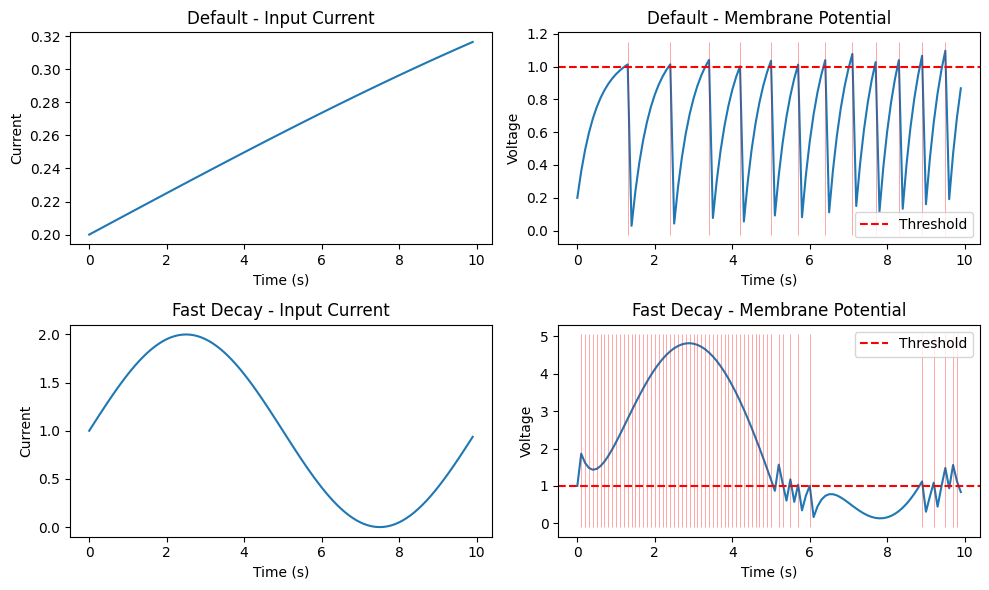

In [85]:
import torch
import snntorch as snn
import matplotlib.pyplot as plt
from collections import namedtuple

def generate_input(duration, dt, frequency, strength):
    time = torch.arange(0, duration, dt)
    input_current = strength * torch.sin(2 * torch.pi * frequency * time) + strength
    return time, input_current

def run_simulation(params):
    # Create the LIF neuron using snntorch
    #print(torch.exp(torch.tensor(-params.dt) / torch.tensor(5)))
    neuron = snn.Leaky(beta=0.8,
                       threshold=params.v_threshold,
                       reset_mechanism="subtract",
                       )
    
    time, input_current = generate_input(params.duration, params.dt, params.frequency, params.strength)
    
    membrane_potential = torch.zeros_like(time)
    spikes = torch.zeros_like(time)
    neuron.reset_mem()
    for i in range(len(time)):
        #print(input_current[i])
        spk, mem = neuron(input_current[i])
        membrane_potential[i] = mem
        spikes[i] = spk
    
    return time, input_current, membrane_potential, spikes

def plot_results(results):
    num_sets = len(results)
    fig, axs = plt.subplots(num_sets, 2, figsize=(10, 3 * num_sets))

    # Handle single plot case
    if num_sets == 1:
        axs1 = axs[0]
        axs2 = axs[1]
        for i, (label, (time, input_current, membrane_potential, spikes)) in enumerate(results.items()):
            # Input Current plot
            axs1.set_title(f"{label} - Input Current")
            axs1.plot(time, input_current)
            axs1.set_xlabel("Time (s)")
            axs1.set_ylabel("Current")
            
            # Membrane Potential plot
            axs2.set_title(f"{label} - Membrane Potential")
            axs2.plot(time, membrane_potential)
            axs2.axhline(y=param_sets[label].v_threshold, color='r', linestyle='--', label='Threshold')
            axs2.set_xlabel("Time (s)")
            axs2.set_ylabel("Voltage")
            axs2.legend()
            
            # Add spike indicators
            spike_times = time[spikes.bool()]
            axs2.vlines(spike_times, axs2.get_ylim()[0], axs2.get_ylim()[1], color='r', linewidth=0.5, alpha=0.5)

    else:
        for i, (label, (time, input_current, membrane_potential, spikes)) in enumerate(results.items()):
            # Input Current plot
            axs[i, 0].set_title(f"{label} - Input Current")
            axs[i, 0].plot(time, input_current)
            axs[i, 0].set_xlabel("Time (s)")
            axs[i, 0].set_ylabel("Current")
            
            # Membrane Potential plot
            axs[i, 1].set_title(f"{label} - Membrane Potential")
            axs[i, 1].plot(time, membrane_potential)
            axs[i, 1].axhline(y=param_sets[label].v_threshold, color='r', linestyle='--', label='Threshold')
            axs[i, 1].set_xlabel("Time (s)")
            axs[i, 1].set_ylabel("Voltage")
            axs[i, 1].legend()
            
            # Add spike indicators
            spike_times = time[spikes.bool()]
            axs[i, 1].vlines(spike_times, axs[i, 1].get_ylim()[0], axs[i, 1].get_ylim()[1], color='r', linewidth=0.5, alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Define a named tuple for parameters
SimParams = namedtuple('SimParams', ['tau_m', 'v_threshold', 'v_reset', 'duration', 'dt', 'frequency', 'strength'])

# Create a dictionary of parameter sets
param_sets = {
    "Default": SimParams(tau_m=10.0, v_threshold=1, v_reset=0.0, duration=10.0, dt=0.1, frequency=0.01, strength=0.2),
    "Fast Decay": SimParams(tau_m=5.0, v_threshold=1, v_reset=0.0, duration=10.0, dt=0.1, frequency=0.1, strength=1.0),
    #"Slow Decay": SimParams(tau_m=20.0, v_threshold=1, v_reset=0.0, duration=10.0, dt=0.1, frequency=0.1, strength=1.0),
    #"High Frequency": SimParams(tau_m=10.0, v_threshold=1, v_reset=0.0, duration=10.0, dt=0.1, frequency=0.5, strength=1.0),
}

# Run simulations and store results
results = {}
for label, params in param_sets.items():
    results[label] = run_simulation(params)

# Plot the results
plot_results(results)